<a href="https://colab.research.google.com/github/OswaldVc/AnaDat/blob/main/Pronostico_ventas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

url_base ="https://raw.githubusercontent.com/jbagnato/machine-learning/master/"
name_data = "time_series.csv"
df = pd.read_csv(url_base + name_data,parse_dates=[0], header=None,index_col=0, squeeze=True,names=['fecha','unidades']);
df.head(60)

<ipython-input-29-e65a3861ffe5>:14: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df = pd.read_csv(url_base + name_data,parse_dates=[0], header=None,index_col=0, squeeze=True,names=['fecha','unidades']);


fecha
2017-01-02    236
2017-01-03    237
2017-01-04    290
2017-01-05    221
2017-01-07    128
2017-01-09    293
2017-01-10    260
2017-01-11    204
2017-01-12    157
2017-01-13    180
2017-01-14    147
2017-01-16    228
2017-01-17    239
2017-01-18    193
2017-01-19    197
2017-01-20    189
2017-01-21    153
2017-01-22     58
2017-01-23    193
2017-01-24    232
2017-01-25    206
2017-01-26    234
2017-01-27    147
2017-01-28    135
2017-01-30    265
2017-01-31    280
2017-02-01    184
2017-02-02    168
2017-02-03    156
2017-02-04    112
2017-02-06    272
2017-02-07    211
2017-02-08    199
2017-02-09    146
2017-02-10    165
2017-02-11     92
2017-02-13    208
2017-02-14    225
2017-02-15    190
2017-02-16    208
2017-02-17    265
2017-02-18    150
2017-02-19     87
2017-02-20    196
2017-02-21    217
2017-02-22    173
2017-02-23    185
2017-02-24    212
2017-02-25    140
2017-02-27    271
2017-03-01    249
2017-03-02    175
2017-03-03    202
2017-03-04     85
2017-03-06    250
2017

In [ ]:
df.dtypes

dtype('int64')

In [ ]:
print(df.index.min())
print(df.index.max())

2017-01-02 00:00:00
2018-11-30 00:00:00


Presumiblemente tenemos las ventas diarias de 2017 y de 2018 hasta el mes de noviembre. Y ahora veamos cuantas muestras tenemos de cada año:

In [ ]:
print(len(df['2017']))
print(len(df['2018']))

315
289


In [ ]:
df.head(10)

fecha
2017-01-02    236
2017-01-03    237
2017-01-04    290
2017-01-05    221
2017-01-07    128
2017-01-09    293
2017-01-10    260
2017-01-11    204
2017-01-12    157
2017-01-13    180
Name: unidades, dtype: int64

Como este comercio cierra los domingos, vemos que de 2017 no tenemos 365 días como erróneamente podíamos presuponer. Y en 2018 nos falta el último mes… que será lo que trataremos de pronosticar.

De hecho aprovechemos el tener indice de fechas con pandas y saquemos los promedios mensuales:

In [ ]:
meses =df.resample('M').mean()
meses

fecha
2017-01-31    203.923077
2017-02-28    184.666667
2017-03-31    182.964286
2017-04-30    198.960000
2017-05-31    201.185185
2017-06-30    209.518519
2017-07-31    278.923077
2017-08-31    316.000000
2017-09-30    222.925926
2017-10-31    207.851852
2017-11-30    185.925926
2017-12-31    213.200000
2018-01-31    201.384615
2018-02-28    190.625000
2018-03-31    174.846154
2018-04-30    186.000000
2018-05-31    190.666667
2018-06-30    196.037037
2018-07-31    289.500000
2018-08-31    309.038462
2018-09-30    230.518519
2018-10-31    209.444444
2018-11-30    184.481481
Freq: M, Name: unidades, dtype: float64

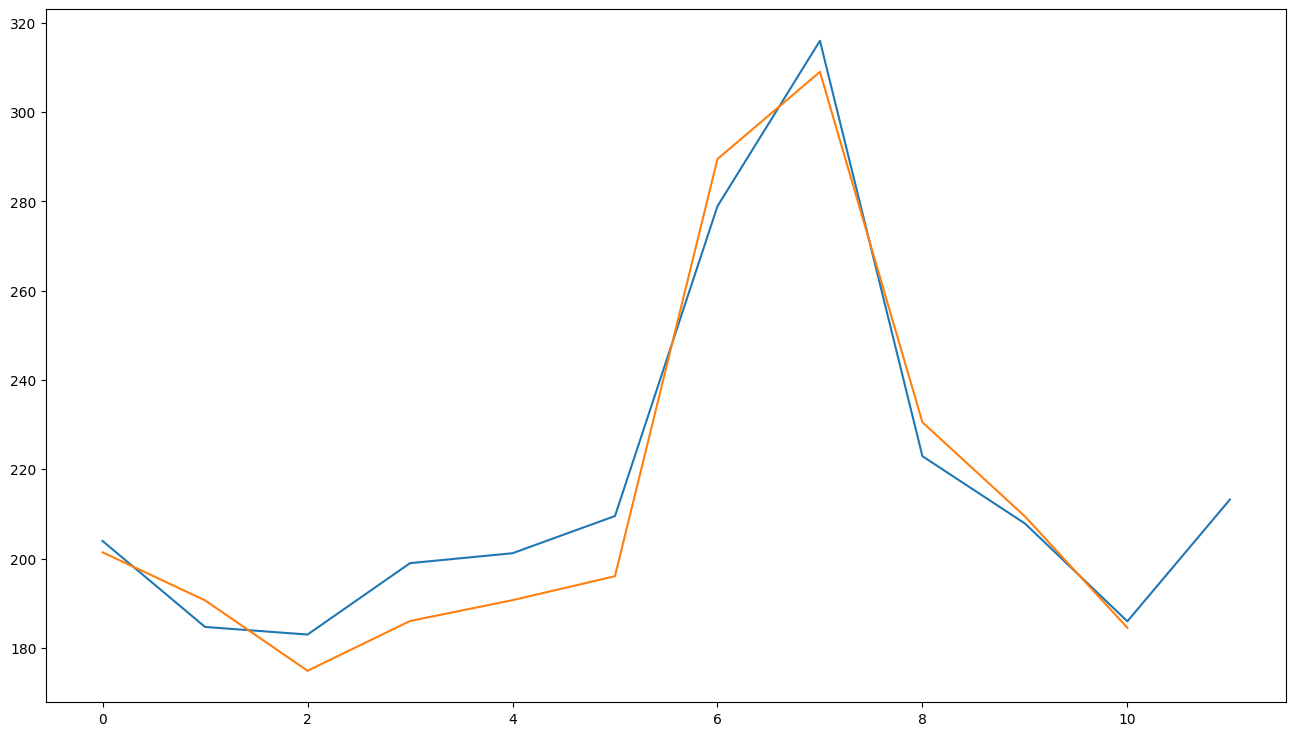

In [ ]:
plt.plot(meses['2017'].values)
plt.plot(meses['2018'].values)

Vemos que en 2017 (en azul) tenemos un inicio de año con un descenso en la cantidad de unidades, luego comienza a subir hasta la llegada del verano europeo en donde en los meses junio y julio tenemos la mayor cantidad de ventas. Finalmente vuelve a disminuir y tiene un pequeño pico en diciembre con la Navidad.

También vemos que 2018 (naranja) se comporta prácticamente igual. Es decir que pareciera que tenemos una estacionalidad. Por ejemplo podríamos aventurarnos a pronosticar que “el verano de 2019 también tendrá un pico de ventas”.

Veamos la gráfica de ventas diarias (en unidades) en junio y julio

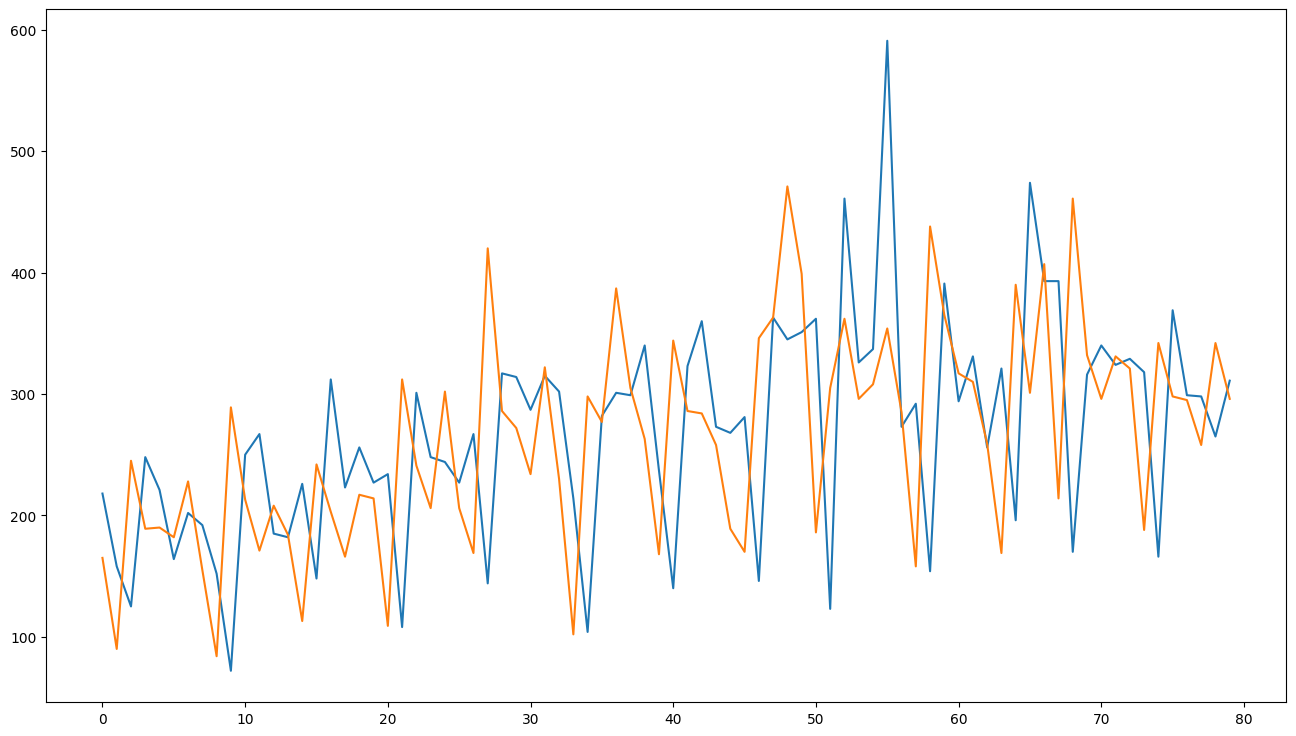

In [ ]:
verano2017 = df['2017-06-01':'2017-09-01']
plt.plot(verano2017.values)
verano2018 = df['2018-06-01':'2018-09-01']
plt.plot(verano2018.values)

##¿Cómo hacer pronóstico de series temporales?
Una vez que tenemos confirmado que nuestra serie es estacionaria, podemos hacer pronóstico. Existen diversos métodos para hacer pronóstico. En nuestro caso, las ventas parecen comportarse bastante parecidas al año, con lo cual un método sencillo si por ejemplo quisiéramos proveer el stock que necesitaría este comercio, sería decir “Si en 2017 en diciembre vendimos promedio 213 unidades, pronostico que en diciembre será similar”. Otro método muy utilizado en estadística es el llamado ARIMA

##Preparamos los datos


Lo que haremos es alterar nuestro flujo de entrada del archivo csv que contiene una columna con las unidades despachadas, y lo convertiremos en varias columnas. ¿Y porqué hacer esto? En realidad lo que haremos es tomar nuestra serie temporal y la convertiremos en un “problema de tipo supervisado“ para poder alimentar nuestra red neuronal y poder entrenarla con backpropagation (“como es habitual”). Para hacerlo, debemos tener unas entradas y unas salidas para entrenar al modelo.

Lo que haremos -en este ejemplo- es tomar los 7 días previos para “obtener” el octavo. Podríamos intentar entrenar a la red con 2, ó 3 días. O también podríamos tener 1 sola salida, ó hasta “atrevernos” intentar predecir más de un “día futuro”. Eso lo dejo a ustedes cómo actividad extra. Pero entonces quedémonos con que:

Entradas: serán “7 columnas” que representan las ventas en unidades de los 7 días anteriores.
Salida: El valor del “8vo día”. Es decir, las ventas (en unids) de ese día.
Para hacer esta transformación usaré una función llamada series_to_supervised() creada y explicada en este blog. (La verás en el código, a continuación)

Antes de usar la función, utilizamos el MinMaxScaler para transformar el rango de nuestros valores entre -1 y 1 (pues sabemos que a nuestra red neuronal, le favorece para realizar los cálculos).

Entonces aqui vemos cómo queda nuestro set de datos de entrada

In [ ]:
PASOS=7

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333
8,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407
9,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222
10,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444
11,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444


Usaremos como entradas las columnas encabezadas como var1(t-7) a (t-1) y nuestra salida (lo que sería el valor “Y” de la función) será el var1(t) -la última columna-.

## Creamos la Red Neuronal Artificial
Antes de crear la red neuronal, subdividiremos nuestro conjunto de datos en train y en test. ATENCIÓN, algo importante de este procedimiento, a diferencia de en otros problemas en los que podemos “mezclar” los datos de entrada, es que en este caso nos importa mantener el orden en el que alimentaremos la red. Por lo tanto, haremos una subdivisión de los primeros 567 días consecutivos para entrenamiento de la red y los siguientes 30 para su validación. Esta es una proporción que elegí yo, y que me pareció conveniente, pero definitivamente, puede no ser la óptima (queda propuesto al lector, variar esta proporción por ejemplo a 80-20 y comparar resultados )

In [ ]:
# dividido en conjuntos de tren y prueba
values = reframed.values
n_train_days = 315+289 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# dividir en entradas y salidas
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]

#  remodelar la entrada para que sea 3D [muestras, pasos de tiempo, características]

x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(567, 1, 7) (567,) (30, 1, 7) (30,)


Hemos transformado la entrada en un arreglo con forma (567,1,7) esto al castellano significa algo así como “567 entradas con vectores de 1×7”.

La arquitectura de la red neuronal será:

Entrada 7 inputs, como dijimos antes
1 capa oculta con 7 neuronas (este valor lo escogí yo, pero se puede variar)
La salida será 1 sola neurona
Como función de activación utilizamos tangente hiperbólica puesto que utilizaremos valores entre -1 y 1.
Utilizaremos como optimizador Adam y métrica de pérdida (loss) Mean Absolute Error
Como la predicción será un valor continuo y no discreto, para calcular el Acuracy utilizaremos Mean Squared Error y para saber si mejora con el entrenamiento se debería ir reduciendo con las EPOCHS.

In [ ]:
def crear_modeloFF():
    model = Sequential()
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

## Entrenamiento y Resultados
Veamos cómo se comporta nuestra máquina al cabo de 40 épocas.

In [ ]:

EPOCHS=80

model = crear_modeloFF()
history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1, 7)              56        
                                                                 
 flatten_1 (Flatten)         (None, 7)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 8         
                                                                 
Total params: 64 (256.00 Byte)
Trainable params: 64 (256.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/80
81/81 [==============================] - 1s 3ms/step - loss: 0.2722 - mse: 0.1157 - val_loss: 0.2319 - val_mse: 0.0922
Epoch 2/80
81/81 [==============================] - 0s 1ms/step - loss: 0.2416 - mse: 0.0941 - val_loss: 0.2056 - val_mse: 0.0667
Epoch 3/80
81/81 [====

1/1 [==============================] - 0s 13ms/step


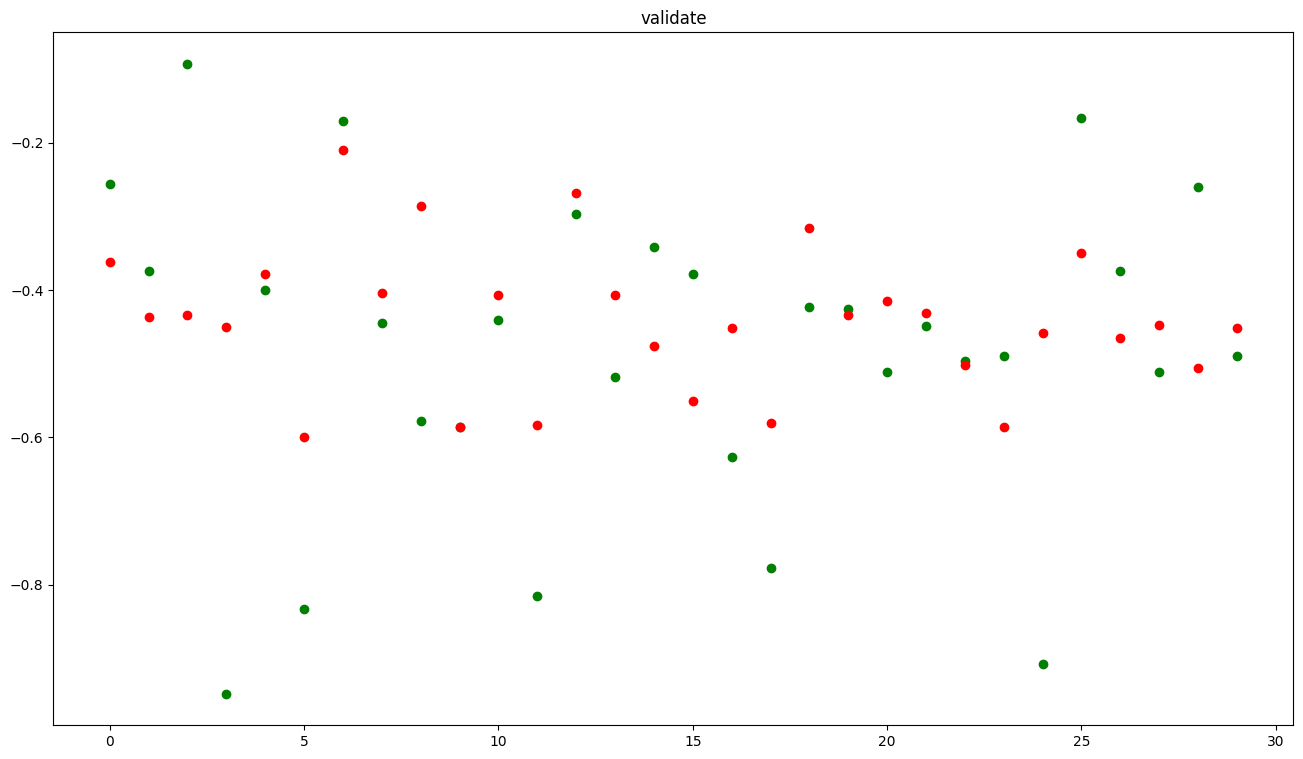

In [ ]:
results=model.predict(x_val)
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

En la gráfica vemos que los puntitos verdes intentan aproximarse a los rojos. Cuanto más cerca ó superpuestos mejor. TIP: Si aumentamos la cantidad de EPOCHS mejora cada vez más.
Veamos y comparemos también cómo disminuye el LOSS tanto en el conjunto de train como el de Validate, esto es bueno ya que indica que el modelo está aprendiendo. A su vez pareciera no haber overfitting, pues las curvas de train y validate son distintas.

## Pronóstico de ventas futuras

Ahora que tenemos nuestra red y -suponiendo que realizamos los 7 pasos del ML– la damos por buena, probaremos a realizar una nueva predicción, en este caso, usaremos los últimos días de noviembre 2018 para calcular la primer semana de diciembre. Veamos:

In [ ]:
ultimosDias = df['2018-11-16':'2018-11-30']
ultimosDias


fecha
2018-11-16    152
2018-11-17    111
2018-11-19    207
2018-11-20    206
2018-11-21    183
2018-11-22    200
2018-11-23    187
2018-11-24    189
2018-11-25     76
2018-11-26    276
2018-11-27    220
2018-11-28    183
2018-11-29    251
2018-11-30    189
Name: unidades, dtype: int64

Y ahora seguiremos el mismo preprocesado de datos que hicimos para el entrenamiento: escalando los valores, llamando a la función series_to_supervised pero esta vez sin incluir la columna de salida “Y” pues es la que queremos hallar. Por eso, verán en el código que hacemos drop() de la última columna.

In [ ]:
values = ultimosDias.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-0.24,-0.65,0.31,0.30,0.07,0.24,0.11
8,-0.65,0.31,0.30,0.07,0.24,0.11,0.13
9,0.31,0.30,0.07,0.24,0.11,0.13,-1.00
10,0.30,0.07,0.24,0.11,0.13,-1.00,1.00
11,0.07,0.24,0.11,0.13,-1.00,1.00,0.44
12,0.24,0.11,0.13,-1.00,1.00,0.44,0.07
13,0.11,0.13,-1.00,1.00,0.44,0.07,0.75


De este conjunto “ultimosDias” tomamos sólo la última fila, pues es la que correspondería a la última semana de noviembre y la dejamos en el formato correcto para la red neuronal con reshape

In [ ]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_test

array([[[ 0.11000001,  0.13      , -1.        ,  1.        ,
          0.44000006,  0.06999993,  0.75      ]]], dtype=float32)

Ahora crearemos una función para ir “rellenando” el desplazamiento que hacemos por cada predicción. Esto es porque queremos predecir los 7 primeros días de diciembre. Entonces para el 1 de diciembre, ya tenemos el set con los últimos 7 días de noviembre. Pero para pronosticar el 2 de diciembre necesitamos los 7 días anteriores que INCLUYEN al 1 de diciembre y ese valor, lo obtenemos en nuestra predicción anterior. Y así hasta el 7 de diciembre.

In [ ]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

1/1 [==============================] - 0s 18ms/step
[[[ 0.0590209  -0.44495544  0.26183227  0.3942467  -0.04363095
    0.2118454   0.05473163]]]
1/1 [==============================] - 0s 18ms/step
[[[-0.44495544  0.26183227  0.3942467  -0.04363095  0.2118454
    0.05473163 -0.3123038 ]]]
1/1 [==============================] - 0s 18ms/step
[[[ 0.26183227  0.3942467  -0.04363095  0.2118454   0.05473163
   -0.3123038  -0.02706636]]]
1/1 [==============================] - 0s 19ms/step
[[[ 0.3942467  -0.04363095  0.2118454   0.05473163 -0.3123038
   -0.02706636  0.19260605]]]
1/1 [==============================] - 0s 17ms/step
[[[-0.04363095  0.2118454   0.05473163 -0.3123038  -0.02706636
    0.19260605 -0.08177556]]]
1/1 [==============================] - 0s 19ms/step
[[[ 0.2118454   0.05473163 -0.3123038  -0.02706636  0.19260605
   -0.08177556 -0.06662277]]]
1/1 [==============================] - 0s 21ms/step
[[[ 0.05473163 -0.3123038  -0.02706636  0.19260605 -0.08177556
   -0.06662277 -0

Ya casi lo tenemos… Ahora las predicciones están en el dominio del -1 al 1 y nosotros lo queremos en nuestra escala “real” de unidades vendidas. Entonces vamos a “re-transformar” los datos con el objeto “scaler” que creamos antes.

In [ ]:
adimen = [x for x in results]
inverted = scaler.inverse_transform(adimen)
inverted

array([[144.76962115],
       [173.29336643],
       [195.26060809],
       [167.8224467 ],
       [169.3377257 ],
       [170.57968126],
       [150.01667179]])

Ya podemos crear un nuevo DataFrame Pandas por si quisiéramos guardar un nuevo csv con el pronóstico. Y lo visualizamos.

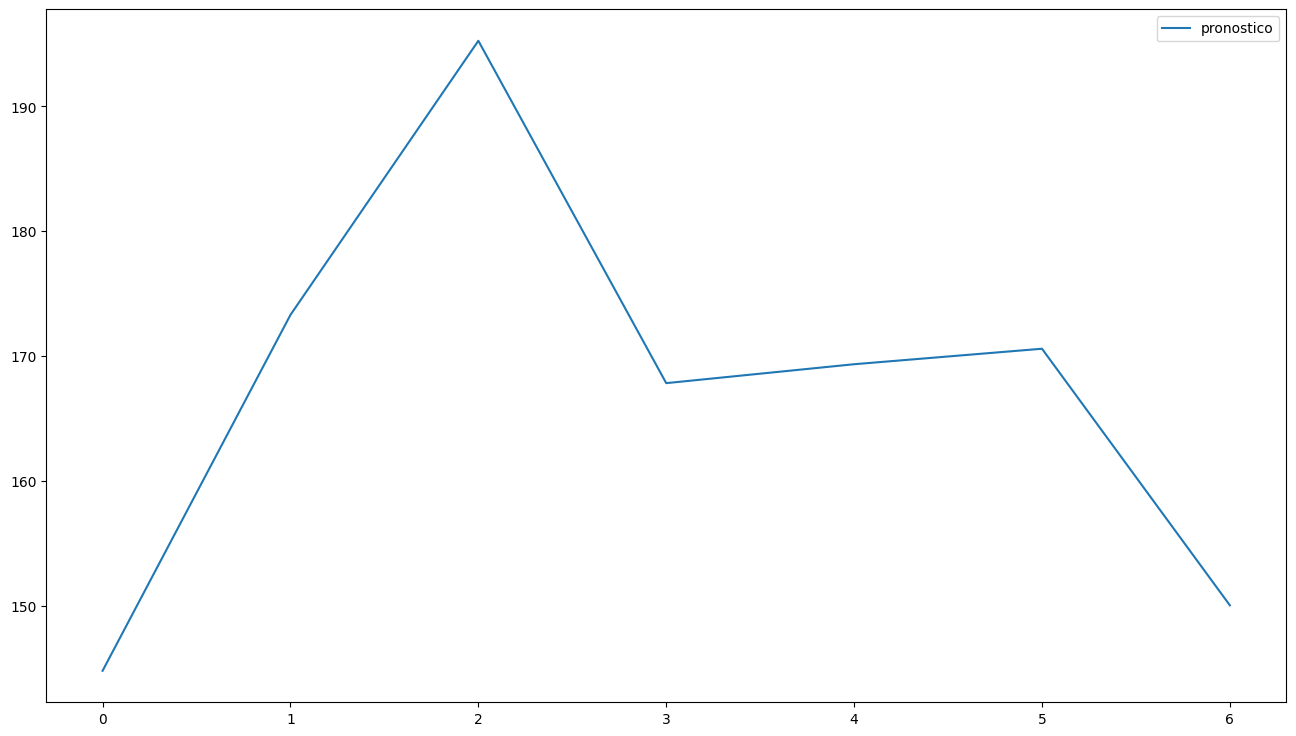

In [ ]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()
prediccion1SemanaDiciembre.to_csv('pronostico.csv')